In [1]:
import pandas as pd
import os
import numpy as np
import pickle
from pathlib import Path

In [2]:
import numpy as np
import pickle
import gc
from itertools import combinations
import matplotlib.pyplot as plt

# --- 1. Generalized Concatenation Helper ---
def concatenate_padded_labels(sequences, max_len=500, pad_val=0):
    """
    A general function that concatenates an arbitrary number of padded sequences.
    
    Args:
        sequences (list of np.array): List of 1D arrays to concatenate.
        max_len (int): Maximum length of the final output.
        pad_val (int): Value used for padding (default 0).
    """
    valid_parts = []
    
    for seq in sequences:
        # Find indices where value is NOT pad_val
        non_pad_indices = np.where(seq != pad_val)[0]
        
        # Calculate length: if array is all pads, length is 0
        length = non_pad_indices[-1] + 1 if len(non_pad_indices) > 0 else 0
        valid_parts.append(seq[:length])
    
    # Concatenate all parts at once
    combined = np.concatenate(valid_parts)
    
    # Handle Overflow
    if len(combined) > max_len:
        # Optional: Print warning only if it's a significant cut, to reduce noise
        # print(f"Warning: Combined length {len(combined)} exceeds limit {max_len}.")
        print(f"Warning: long sentences of length {len(combined)} truncated to {max_len}")
        combined = combined[:max_len]
        
    # Re-pad to max_len
    result = np.full(max_len, pad_val, dtype=sequences[0].dtype)
    result[:len(combined)] = combined
    
    return result

# --- 2. Memory-Optimized Generation Function ---
def generate_n_sentence_combinations(dataset_val, n_sentences, limit=500):
    """
    Generates n-sentence combinations for a specific dataset split.
    Optimized to handle memory by capping indices BEFORE data construction.
    """
    generated_data = []
    
    for day_idx, day_data in enumerate(dataset_val):
        # Handle missing days (None)
        if day_data is None:
            generated_data.append(None)
            continue
            
        # Extract raw day data
        raw_neural = day_data['sentenceDat']
        raw_transcripts = day_data['transcriptions']
        raw_labels = day_data['text']
        raw_feat_lens = day_data['timeSeriesLen'] if 'timeSeriesLen' in day_data else day_data['timeSeriesLens']
        raw_label_lens = day_data['textLens']
        
        num_trials = len(raw_transcripts)
        
        # A. Generate Indices Only (Low Memory)
        # combinations returns an iterator; converting to list is safe for typical N (up to ~100)
        # If N > 200, 4-combinations might get too large for this approach, but B2T usually has <100 trials/day.
        all_indices = list(combinations(range(num_trials), n_sentences))
        
        # B. Cap the Combinations
        # Shuffle to ensure we pick a diverse set across the day
        np.random.shuffle(all_indices)
        
        # Take the top 'limit' (e.g., 500)
        selected_indices = all_indices[:limit]
        
        print(f"Day {day_idx}: Found {len(all_indices)} combos ({n_sentences}-sentence). Generating {len(selected_indices)}...")
        
        # C. Construct Data for Selected Indices Only
        new_day_dict = {
            'sentenceDat': [],
            'transcriptions': [],
            'text': [],
            'timeSeriesLen': [],
            'textLens': []
        }
        
        for indices in selected_indices:
            # indices is a tuple like (0, 5, 12) for n=3
            
            # 1. Transcriptions: Join with space
            curr_transcripts = [raw_transcripts[i] for i in indices]
            new_day_dict['transcriptions'].append(" ".join(curr_transcripts))
            
            # 2. Time Series Length: Sum
            curr_feat_lens = [raw_feat_lens[i] for i in indices]
            new_day_dict['timeSeriesLen'].append(sum(curr_feat_lens))
            
            # 3. Text/Label Length: Sum
            curr_label_lens = [raw_label_lens[i] for i in indices]
            new_day_dict['textLens'].append(sum(curr_label_lens))
            
            # 4. Neural Data: Concatenate along Dim 0
            curr_neural = [raw_neural[i] for i in indices]
            new_day_dict['sentenceDat'].append(np.concatenate(curr_neural, axis=0))
            
            # 5. Labels: Use generalized helper
            curr_labels = [raw_labels[i] for i in indices]
            new_day_dict['text'].append(concatenate_padded_labels(curr_labels))
            
        generated_data.append(new_day_dict)
        
    return generated_data

In [3]:
# Configuration
LIMIT = 70
data_paths = ['/data2/brain2text/b2t_25/brain2text25.pkl', '/data2/brain2text/b2t_24/brain2text24.pkl']
with open(data_paths[0], 'rb') as f:
    df25 = pickle.load(f)

with open(data_paths[1], 'rb') as f:
    df24 = pickle.load(f)

# --- Process Brain2Text 2025 ---
print("--- Processing B2T 2025 ---")
val_extended_25 = {}

# 2x Combinations
print("Generating 2x...")
val_extended_25['val_2x_b2t25'] = generate_n_sentence_combinations(df25['val'], n_sentences=2, limit=LIMIT)
gc.collect() # Force garbage collection

# 3x Combinations
print("Generating 3x...")
val_extended_25['val_3x_b2t25'] = generate_n_sentence_combinations(df25['val'], n_sentences=3, limit=LIMIT)
gc.collect()

# 4x Combinations
print("Generating 4x...")
val_extended_25['val_4x_b2t25'] = generate_n_sentence_combinations(df25['val'], n_sentences=4, limit=LIMIT)
gc.collect()

# Save to Pickle
with open('/data2/brain2text/b2t_25/val_extended_25.pkl', 'wb') as f:
    pickle.dump(val_extended_25, f)
print("Saved val_extended_25.pkl")

# Clear memory before starting 2024
del val_extended_25
gc.collect()


# --- Process Brain2Text 2024 ---
print("\n--- Processing B2T 2024 ---")
val_extended_24 = {}

# 2x Combinations
print("Generating 2x...")
val_extended_24['val_2x_b2t24'] = generate_n_sentence_combinations(df24['val'], n_sentences=2, limit=LIMIT)
gc.collect()

# 3x Combinations
print("Generating 3x...")
val_extended_24['val_3x_b2t24'] = generate_n_sentence_combinations(df24['val'], n_sentences=3, limit=LIMIT)
gc.collect()

# 4x Combinations
print("Generating 4x...")
val_extended_24['val_4x_b2t24'] = generate_n_sentence_combinations(df24['val'], n_sentences=4, limit=LIMIT)
gc.collect()

# Save to Pickle
with open('/data2/brain2text/b2t_24/val_extended_24.pkl', 'wb') as f:
    pickle.dump(val_extended_24, f)
print("Saved val_extended_24.pkl")

# Keep val_extended_24 in memory for plotting (or reload if needed)
# To plot both, we need to reload 25 briefly or assume we are done with heavy lifting.

--- Processing B2T 2025 ---
Generating 2x...
Day 1: Found 595 combos (2-sentence). Generating 70...
Day 2: Found 1176 combos (2-sentence). Generating 70...
Day 3: Found 1128 combos (2-sentence). Generating 70...
Day 4: Found 300 combos (2-sentence). Generating 70...
Day 5: Found 300 combos (2-sentence). Generating 70...
Day 6: Found 1176 combos (2-sentence). Generating 70...
Day 7: Found 561 combos (2-sentence). Generating 70...
Day 8: Found 595 combos (2-sentence). Generating 70...
Day 9: Found 1128 combos (2-sentence). Generating 70...
Day 10: Found 946 combos (2-sentence). Generating 70...
Day 11: Found 630 combos (2-sentence). Generating 70...
Day 12: Found 136 combos (2-sentence). Generating 70...
Day 13: Found 946 combos (2-sentence). Generating 70...
Day 14: Found 946 combos (2-sentence). Generating 70...
Day 15: Found 36 combos (2-sentence). Generating 36...
Day 16: Found 528 combos (2-sentence). Generating 70...
Day 17: Found 1225 combos (2-sentence). Generating 70...
Day 18: 

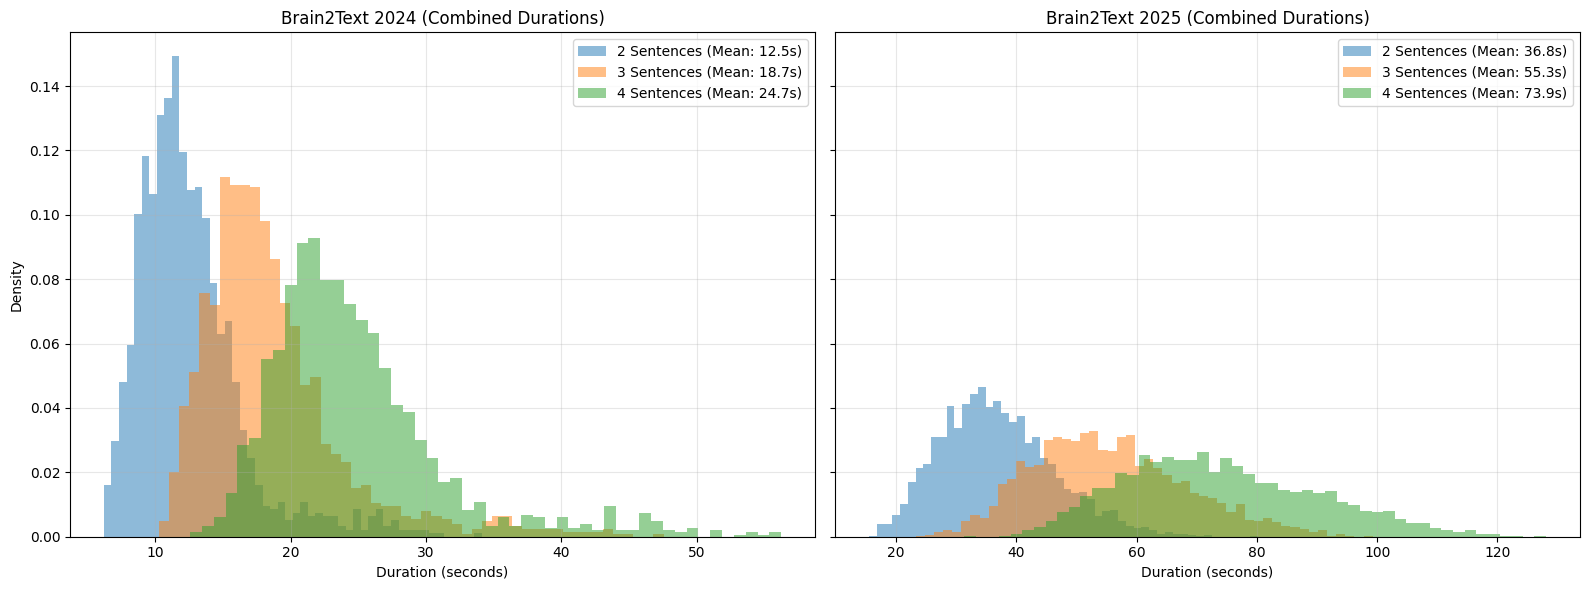


--- Statistics for Brain2Text 2024 ---
Combo      | Count    | Mean (s)   | Max (s)   
---------------------------------------------
2x         | 1680     | 12.54      | 34.12     
3x         | 1680     | 18.66      | 47.56     
4x         | 1680     | 24.75      | 56.26     

--- Statistics for Brain2Text 2025 ---
Combo      | Count    | Mean (s)   | Max (s)   
---------------------------------------------
2x         | 2836     | 36.83      | 80.22     
3x         | 2870     | 55.35      | 99.26     
4x         | 2870     | 73.91      | 128.10    


In [5]:
# Reload data just for stats (if variables were deleted)
with open('/data2/brain2text/b2t_25/val_extended_25.pkl', 'rb') as f:
    data_25 = pickle.load(f)
with open('/data2/brain2text/b2t_24/val_extended_24.pkl', 'rb') as f:
    data_24 = pickle.load(f)

timestep_duration_sec = 0.02

def get_stats_from_dict(dataset_dict, key_prefix):
    """
    Extracts lengths for 2x, 3x, 4x from the dictionary.
    """
    stats = {}
    for n in [2, 3, 4]:
        full_key = f"{key_prefix}_{n}x_{key_prefix.split('_')[-1]}" # e.g. val_2x_b2t25
        # Note: Your keys might just be 'val_2x_b2t25' based on code above. 
        # Let's match the exact keys used in generation:
        full_key = [k for k in dataset_dict.keys() if f"_{n}x_" in k][0]
        
        durations = []
        dataset_list = dataset_dict[full_key]
        
        for day_data in dataset_list:
            if day_data is None: continue
            
            # We standardized on 'timeSeriesLen' in the generation function
            if 'timeSeriesLen' in day_data:
                seconds = [l * timestep_duration_sec for l in day_data['timeSeriesLen']]
                durations.extend(seconds)
        stats[n] = durations
    return stats

stats_25 = get_stats_from_dict(data_25, 'val') # Keys are like val_2x_b2t25
stats_24 = get_stats_from_dict(data_24, 'val') # Keys are like val_2x_b2t24

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

colors = {2: 'skyblue', 3: 'orange', 4: 'green'}
labels = {2: '2 Sentences', 3: '3 Sentences', 4: '4 Sentences'}

# Plot B2T 2024
for n in [2, 3, 4]:
    data = stats_24[n]
    axes[0].hist(data, bins=50, alpha=0.5, label=f'{labels[n]} (Mean: {np.mean(data):.1f}s)', density=True)

axes[0].set_title("Brain2Text 2024 (Combined Durations)")
axes[0].set_xlabel("Duration (seconds)")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot B2T 2025
for n in [2, 3, 4]:
    data = stats_25[n]
    axes[1].hist(data, bins=50, alpha=0.5, label=f'{labels[n]} (Mean: {np.mean(data):.1f}s)', density=True)

axes[1].set_title("Brain2Text 2025 (Combined Durations)")
axes[1].set_xlabel("Duration (seconds)")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- Print Summary Tables ---
for year, stats in [('2024', stats_24), ('2025', stats_25)]:
    print(f"\n--- Statistics for Brain2Text {year} ---")
    print(f"{'Combo':<10} | {'Count':<8} | {'Mean (s)':<10} | {'Max (s)':<10}")
    print("-" * 45)
    for n in [2, 3, 4]:
        d = stats[n]
        print(f"{n}x{'':<8} | {len(d):<8} | {np.mean(d):<10.2f} | {np.max(d):<10.2f}")